In [313]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


df = pd.read_csv('data/real_estate_regression.csv')

df['date_created'] = pd.to_datetime(df['date_created'])
df['date_created_first'] = pd.to_datetime(df['date_created_first'])
df['pushed_up_at'] = pd.to_datetime(df['pushed_up_at'], errors='coerce', utc=True)


df['price_per_m2'] = df['price']/df['area_m2']


df.drop_duplicates(subset=['id'], inplace=True)

# we only have SELL type data
df = df[df['transaction_type']=="SELL"].reset_index(drop=True)
df.drop(columns=['transaction_type', 'id', 'date_created', 'date_created_first', 'pushed_up_at'], inplace=True)

df.rename(columns={'location.district': 'district', 'location.latitude': 'latitude',
       'location.longitude': 'longitude'}, inplace=True)


# remove outliers, where price=1, etc
df = df[df['estate']=="FLAT"].reset_index(drop=True)
df.drop(columns=['estate'], inplace=True)

# filter out 
cond1 = df['price_per_m2']>1000
cond2 = df['area_m2']>=10 

# remove outliers
#cond3 = df['area_m2'] < df['area_m2'].mean() + df['area_m2'].std()*3
#cond4 = df['price'] < df['price'].mean() + df['price'].std()*3
#cond5 = df['building_floors_num']< df['building_floors_num'].mean() + df['building_floors_num'].std()*3
#cond6 = df['price_per_m2']< df['price_per_m2'].mean() + df['price_per_m2'].std()*3

df = df[cond1&cond2].reset_index(drop=True)




### Data transformation

For the floor number, I mapped the strings to numeric representation, to have an ordered variable.

In the building year I found some values that looked like typos, with values even above 3000, far beyond we could expect from a property that's under construction. The number of values outside the chosen range is rather small.

The building_age is calculated as the current year minus the building_year. We could expect some negative values, as some properties are still under construction.

The distance to the center could affect the price of the property, so I calculated this value using the coordinates of each property.

The room_size_m2 reflects the average size of the room in squared meters. The floor_ratio will help us understand if the position of the apartment relative to the building has an effect on price.

Finally, for building_type, building_material, rooms_number and heating, I chose the top values. To reduce the cardinality of these categories.

In [314]:
floor_mapping = {
    'CELLAR': -1,
    'GROUND': 0,
    'FIRST': 1,
    'SECOND': 2,
    'THIRD': 3,
    'FOURTH': 4,
    'FIFTH': 5,
    'SIXTH': 6,
    'SEVENTH': 7,
    'EIGHTH': 8,
    'NINTH': 9,
    'TENTH': 10,
    'ABOVE_TENTH': 11,
    'GARRET': 12 
}


df['floor_number'] = df['floor_number'].map(floor_mapping)

df['building_year'] = np.select([df['building_year']<1800, df['building_year']>2028], [np.nan, np.nan], default=df['building_year'])

df['building_age'] = pd.Timestamp.now().year - df['building_year']

city_center = (52.2318543, 21.0028622)  # for Warsaw

# 1 degree of latitude/longitude ≈ 111 km
df['distance_to_center_km'] = df.apply(
    lambda row: np.sqrt(
        (row['latitude'] - city_center[0])**2 + 
        (row['longitude'] - city_center[1])**2
    ) * 111,
    axis=1
)



df['room_size_m2'] = df['area_m2'] /  df['rooms_number'].replace('MORE', 11).astype(float) 
df['floor_ratio'] = df['floor_number'] / df['building_floors_num']

In [315]:
import json

df.rename(columns={'district': 'neighborhood'}, inplace=True)

with open("district_mapping.json") as json_mapping:
    neighborhood_to_dzielnica = json.load(json_mapping)

df['district'] = df['neighborhood'].map(neighborhood_to_dzielnica)
df['district'] = df['district'].str.lower()
df.drop(columns=['neighborhood'], inplace=True)


In [316]:
top_heating = df["heating"].value_counts().index[:4]
df["heating"] = df["heating"].apply(lambda x: x if x in top_heating else "OTHER")


In [317]:
top_building_type = df["building_type"].value_counts().index[:3]
df["building_type"] = df["building_type"].apply(lambda x: x if x in top_building_type else "OTHER")


In [318]:
df["building_material"] = df["building_material"].replace("[]", "MISSING")
top_building_material = df["building_material"].value_counts().index[:6]
df["building_material"] = df["building_material"].apply(lambda x: x if x in top_building_material else "OTHER")



In [319]:
df['rooms_number'] = df['rooms_number'].replace('5|6|7|8|9|10', 'MORE', regex=True)
category_order = ['1', '2', '3', 'MORE']
df['rooms_number'] = pd.Categorical(df['rooms_number'], categories=category_order, ordered=True)


In [320]:
df.shape    


(39601, 42)

## Data Description

For the regression problem, the data was scraped from otodom from september to december 2024. The scope is properties for sale in the Warsaw area, including flats, excluding houses.

The dataset includes data on the property itself, and the building (for flats). The problem is to help realtors and private sellers, obtain a proper valuation for their property before they make it available for sale. Therefore, the target variable is the offer price.



### Removing Outliers


In [321]:
multiplier=2.5
df_clean = df.copy()
columns = ['area_m2', 'price', 'building_floors_num', 'price_per_m2']

for col in columns:

    if col in ['price', 'price_per_m2']:
        values = np.log(df_clean[col])
    else:
        values = df_clean[col]
        
    Q1 = values.quantile(0.25)
    Q3 = values.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    if col in ['price', 'price_per_m2']:
        # Convert bounds back from log space
        df_clean = df_clean[
            (np.log(df_clean[col]) >= lower_bound) & 
            (np.log(df_clean[col]) <= upper_bound)
        ]
    else:
        df_clean = df_clean[
            (df_clean[col] >= lower_bound) & 
            (df_clean[col] <= upper_bound)
        ]

print(len(df)-len(df_clean), "rows removed as outliers.")
df=df_clean

2877 rows removed as outliers.


## Data exploration

The variables of this dataset, can be divided in several categories, explained below

I'll analyze the correlations of the variables with price and remove highly correlated features.

### Data transformation

Based on the distribution of price, we need to apply a log transformation to be able to predict effectively. Other variables will be scaled accordingly.

The categorical variables will be one-hot encoded.



In [322]:
import pandas as pd
import numpy as np

def analyze_dataframe(df):
    """
    Analyzes a dataframe and returns a summary of data types and unique values
    """
    columns = []
    dtypes = []
    n_unique_values = []
    unique_values = []
    null_counts = []
    null_pct = []
    
    for column in df.columns:
        columns.append(column)
        dtypes.append(str(df[column].dtype))
        null_counts.append(df[column].isnull().sum())
        null_pct.append(round(df[column].isnull().sum()/len(df),4)*100)
        
        # Get unique values based on data type top values/range
        if pd.api.types.is_numeric_dtype(df[column]):
            if df[column].dtype == bool:
                unique_vals = list(df[column].unique())
            else:
                unique_vals = f"Range: [{df[column].min():.2f} - {df[column].max():.2f}]"
            n_unique_values.append(np.nan)
        else:
            n_unique_values.append(df[column].nunique())
            unique_vals = list(df[column].value_counts().head(5).index)
            
        unique_values.append(unique_vals)
    
    summary_df = pd.DataFrame({
        'Column': columns,
        'Data Type': dtypes,
        'Null Count': null_counts,
        'Nulls (%)': null_pct,
        'N unique': n_unique_values,
        'Top Values/Range': unique_values
    })

    summary_df['Nulls (%)'] = summary_df['Nulls (%)'].round(2)
    summary_df['N unique'] = summary_df['N unique'].astype('Int64')
    
    print(f"\nTotal Rows: {len(df)}")
    print(f"Total Columns: {len(df.columns)}")
    
    return summary_df

analyze_dataframe(df)


Total Rows: 36724
Total Columns: 42


,Column,Data Type,Null Count,Nulls (%),N unique,Top Values/Range
0,latitude,float64,0,0.0000,<NA>,Range: [52.10 - 52.36]
1,longitude,float64,0,0.0000,<NA>,Range: [20.86 - 21.25]
2,is_private_owner,bool,0,0.0000,<NA>,"[True, False]"
3,advertiser_type,object,1684,4.5900,3,"[AGENCY, PRIVATE, DEVELOPER]"
4,area_m2,float64,0,0.0000,<NA>,Range: [12.00 - 132.16]
5,rooms_number,category,3819,10.4000,4,"[2, 3, 1, MORE]"
6,floor_number,float64,116,0.3200,<NA>,Range: [-1.00 - 12.00]
7,windows_type,object,15162,41.2900,3,"[PLASTIC, WOODEN, ALUMINIUM]"
8,heating,object,0,0.0000,4,"[URBAN, OTHER, GAS, BOILER_ROOM]"
9,building_year,float64,2734,7.4400,<NA>,Range: [1810.00 - 2027.00]


In [323]:
# remove columns with only one unique val
cols_to_drop = []
for col in df.columns:
    if len(df[col].unique())==1:
        cols_to_drop.append(col)

df.drop(columns=cols_to_drop, inplace=True)
print("Removed columns", str(cols_to_drop), "with one unique value")

Removed columns ['floors_num', 'has_garage', 'has_attic', 'has_pool'] with one unique value


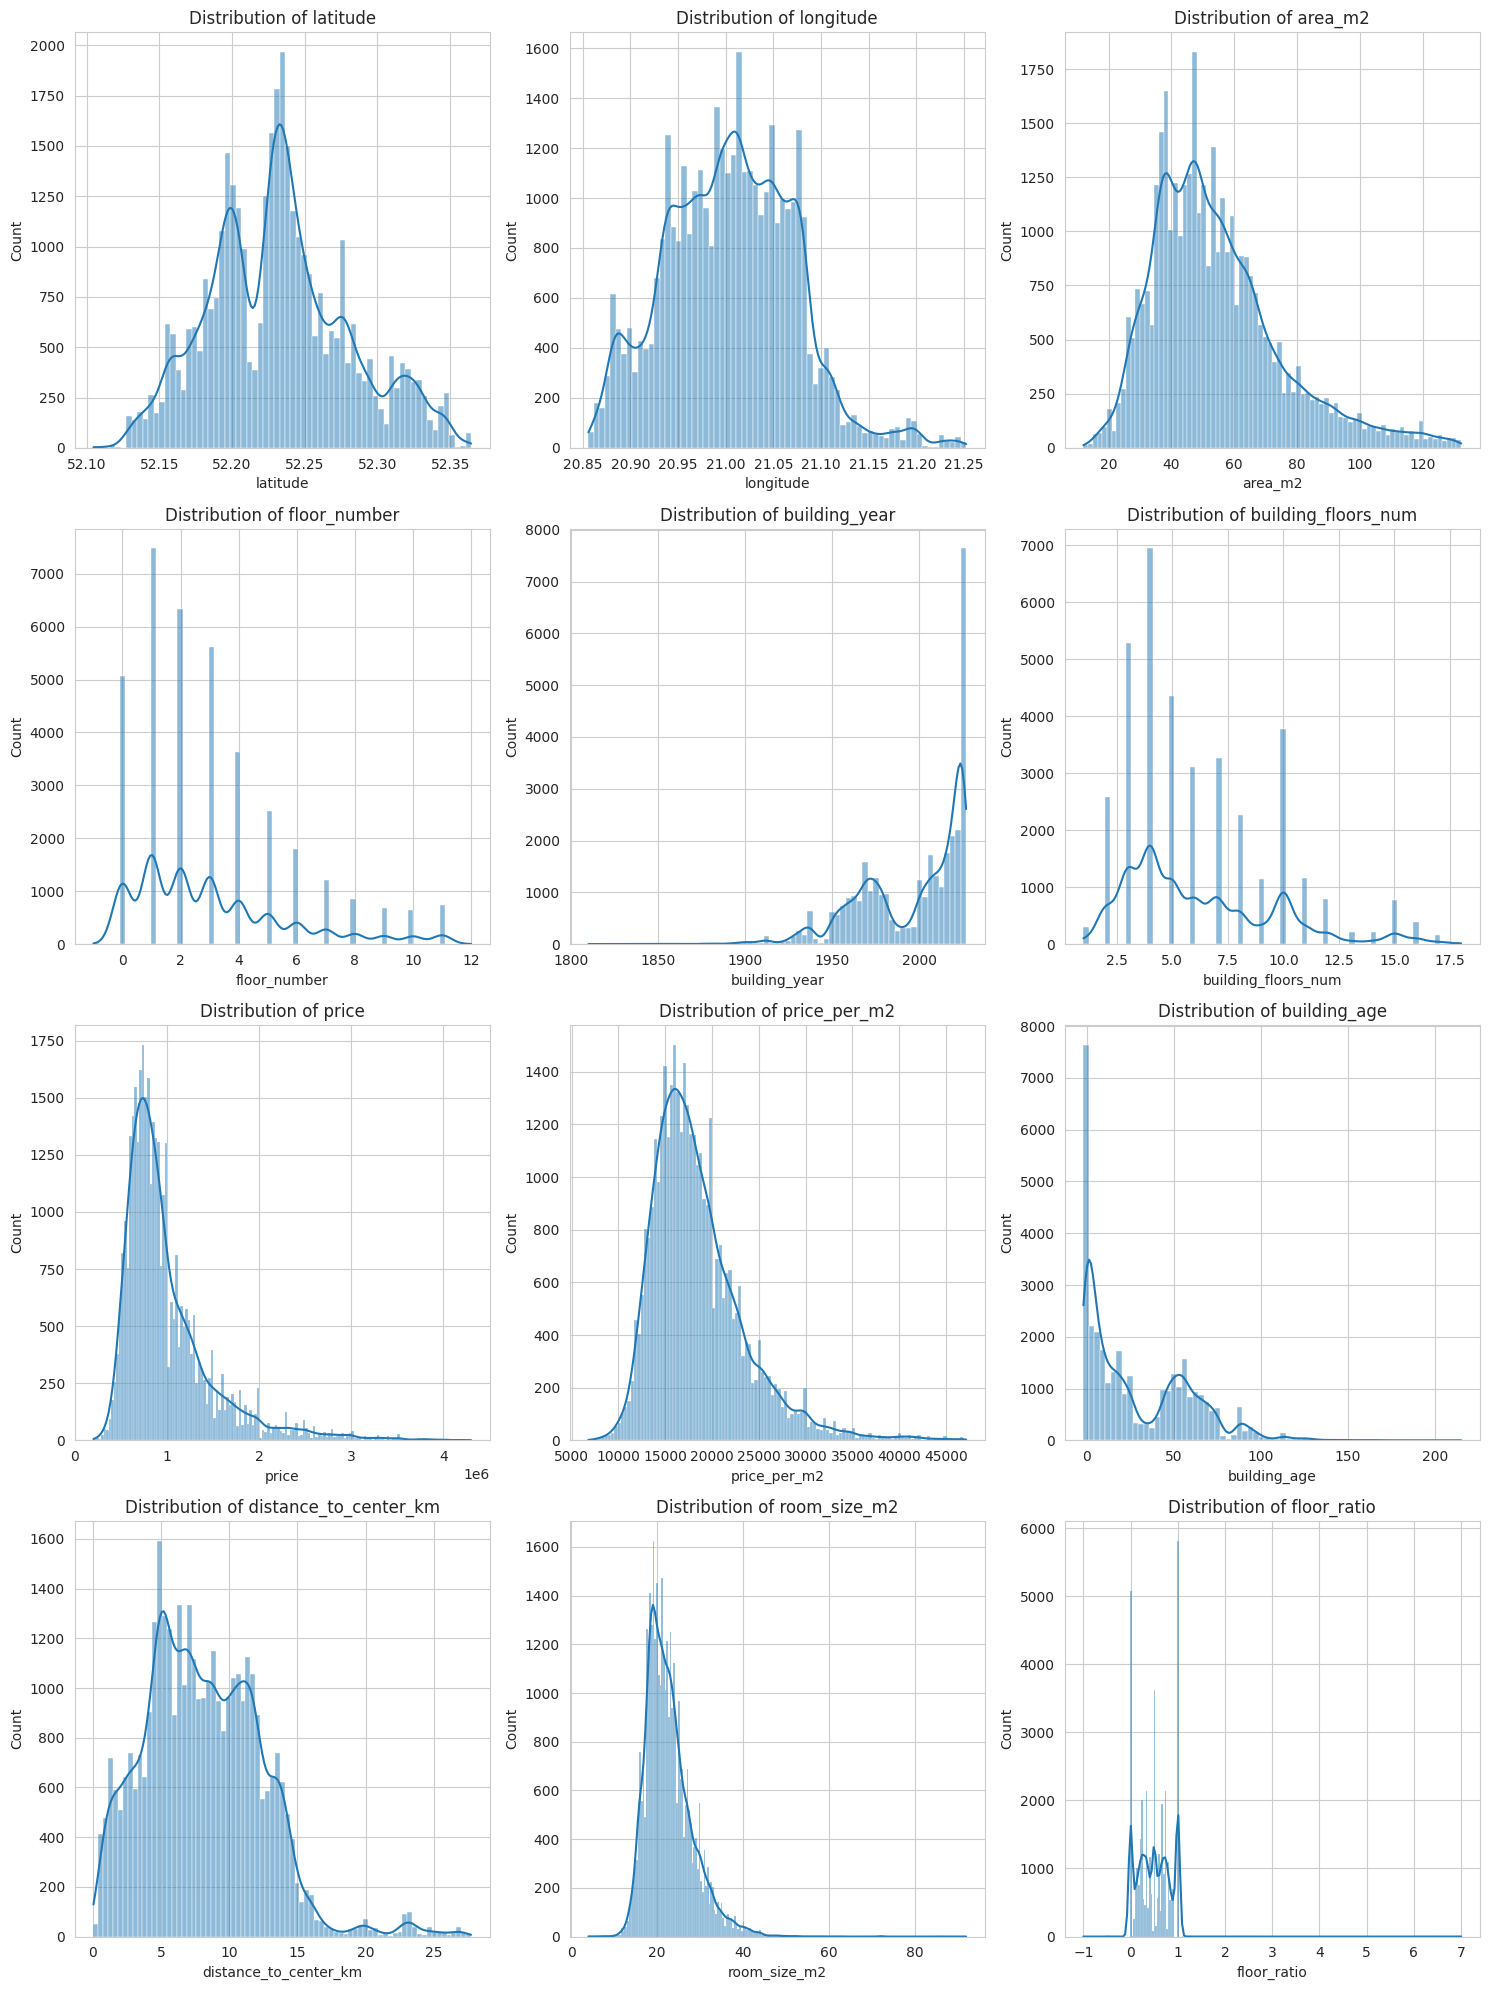

In [324]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, shapiro


numerical_columns = [col for col in df.select_dtypes(include=[np.number]).columns if 'has_' not in col]

num_columns = len(numerical_columns)
num_rows = (num_columns + 2) // 3 

fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))

axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()



In [325]:
skewness = df[numerical_columns].apply(lambda x: skew(x.dropna()))
print("Skewness of numerical variables:")
print(skewness)

for col in numerical_columns:
    stat, p = shapiro(df[col].dropna())
    print(f'Shapiro-Wilk test for {col}: statistic={stat}, p-value={p}')

Skewness of numerical variables:
latitude                 0.3204
longitude                0.2757
area_m2                  1.0695
floor_number             1.1464
building_year           -0.8887
building_floors_num      0.9736
price                    2.1046
price_per_m2             1.4229
building_age             0.8887
distance_to_center_km    0.7269
room_size_m2             1.3907
floor_ratio              0.7360
dtype: float64
Shapiro-Wilk test for latitude: statistic=0.9857294139136397, p-value=2.351121581285399e-49
Shapiro-Wilk test for longitude: statistic=0.9885436934807539, p-value=1.5241099116593878e-45
Shapiro-Wilk test for area_m2: statistic=0.9337904952505168, p-value=2.0485427961191e-80
Shapiro-Wilk test for floor_number: statistic=0.8825430380122006, p-value=6.185474809048166e-94
Shapiro-Wilk test for building_year: statistic=0.8760765353039526, p-value=1.4669439986764217e-93
Shapiro-Wilk test for building_floors_num: statistic=0.9101913826735332, p-value=1.6516452661795143

/home/sergiocarcamo/dev/ml2-project/.venv/lib64/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 36724.
  res = hypotest_fun_out(*samples, **kwds)
/home/sergiocarcamo/dev/ml2-project/.venv/lib64/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 36608.
  res = hypotest_fun_out(*samples, **kwds)
/home/sergiocarcamo/dev/ml2-project/.venv/lib64/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 33990.
  res = hypotest_fun_out(*samples, **kwds)


### Data normalization

From the plots and tests performed we can see that area_m2, floor_number, building_floors_num, building_age, distance_to_center_km, room_size_m2 and floor_ratio are right sweked. Therefore I'll apply a transformation for these columns, potentially log transform, box-cox or yeo–johnson.

Latitude and longitude seem close to normal distribution, therefore I'll apply simple scaling.

I'll drop building_year to avoid redundancy with  building_age



In [326]:
log_transform_cols = ['area_m2', 'floor_number', 'building_age',
                       'building_floors_num', 'distance_to_center_km', 'room_size_m2', 'floor_ratio' ]

scale_cols = ['latitude', 'longitude',  ]

if 'building_year' in df.columns:
    df.drop(columns=['building_year'], inplace=True)

### Correlation

<Axes: >

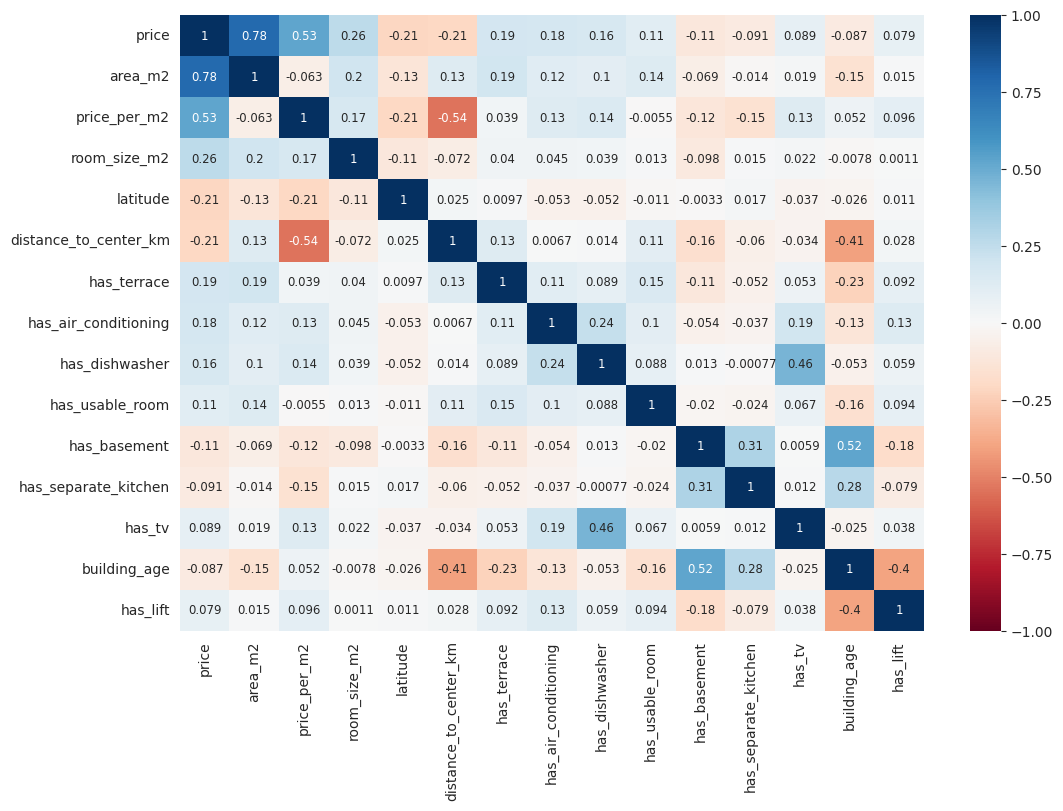

In [327]:
numeric_cols = df.select_dtypes(include=np.number).columns



plt.figure(figsize=(12, 8))
top_features = df[numeric_cols].corr()['price'].sort_values(ascending=False).abs().nlargest(15)  
top_corr = df[top_features.index].corr()

sns.heatmap(top_corr, 
            annot=True, 
            cmap='RdBu', 
            vmin=-1, 
            vmax=1, 
            center=0,
            annot_kws={"size": "small"}
            )

From the correlation plot, it's clear that the area of a flat is highly correlated with its sale price. Other variables that are correlated the average size of a room (room_size_m2). 

Distance to the center shows a negative correlation, implying the further we are from the center, the lower the sale price.

Some ammenities, such as terrace, air conditioning, dish washer and usable room show a positive correlation with price. Others such as a basement indicate a negative correlation.

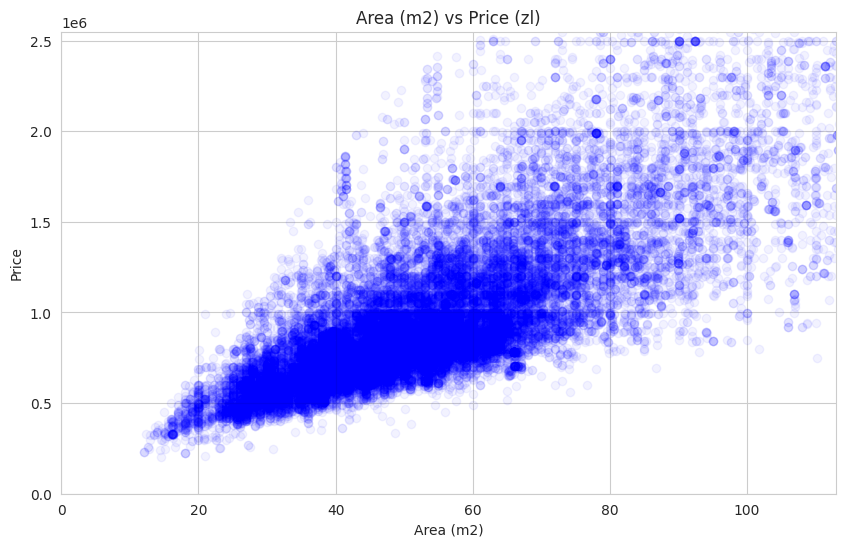

In [328]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))

plt.scatter(df['area_m2'], df['price'], color="blue", alpha=0.05)

plt.title('Area (m2) vs Price (zl)')
plt.xlabel('Area (m2)')
plt.ylabel('Price')
plt.xlim(0, df['area_m2'].quantile(0.98))
plt.ylim(0, df['price'].quantile(0.98))
#plt.legend()

plt.show()

### Categorical data

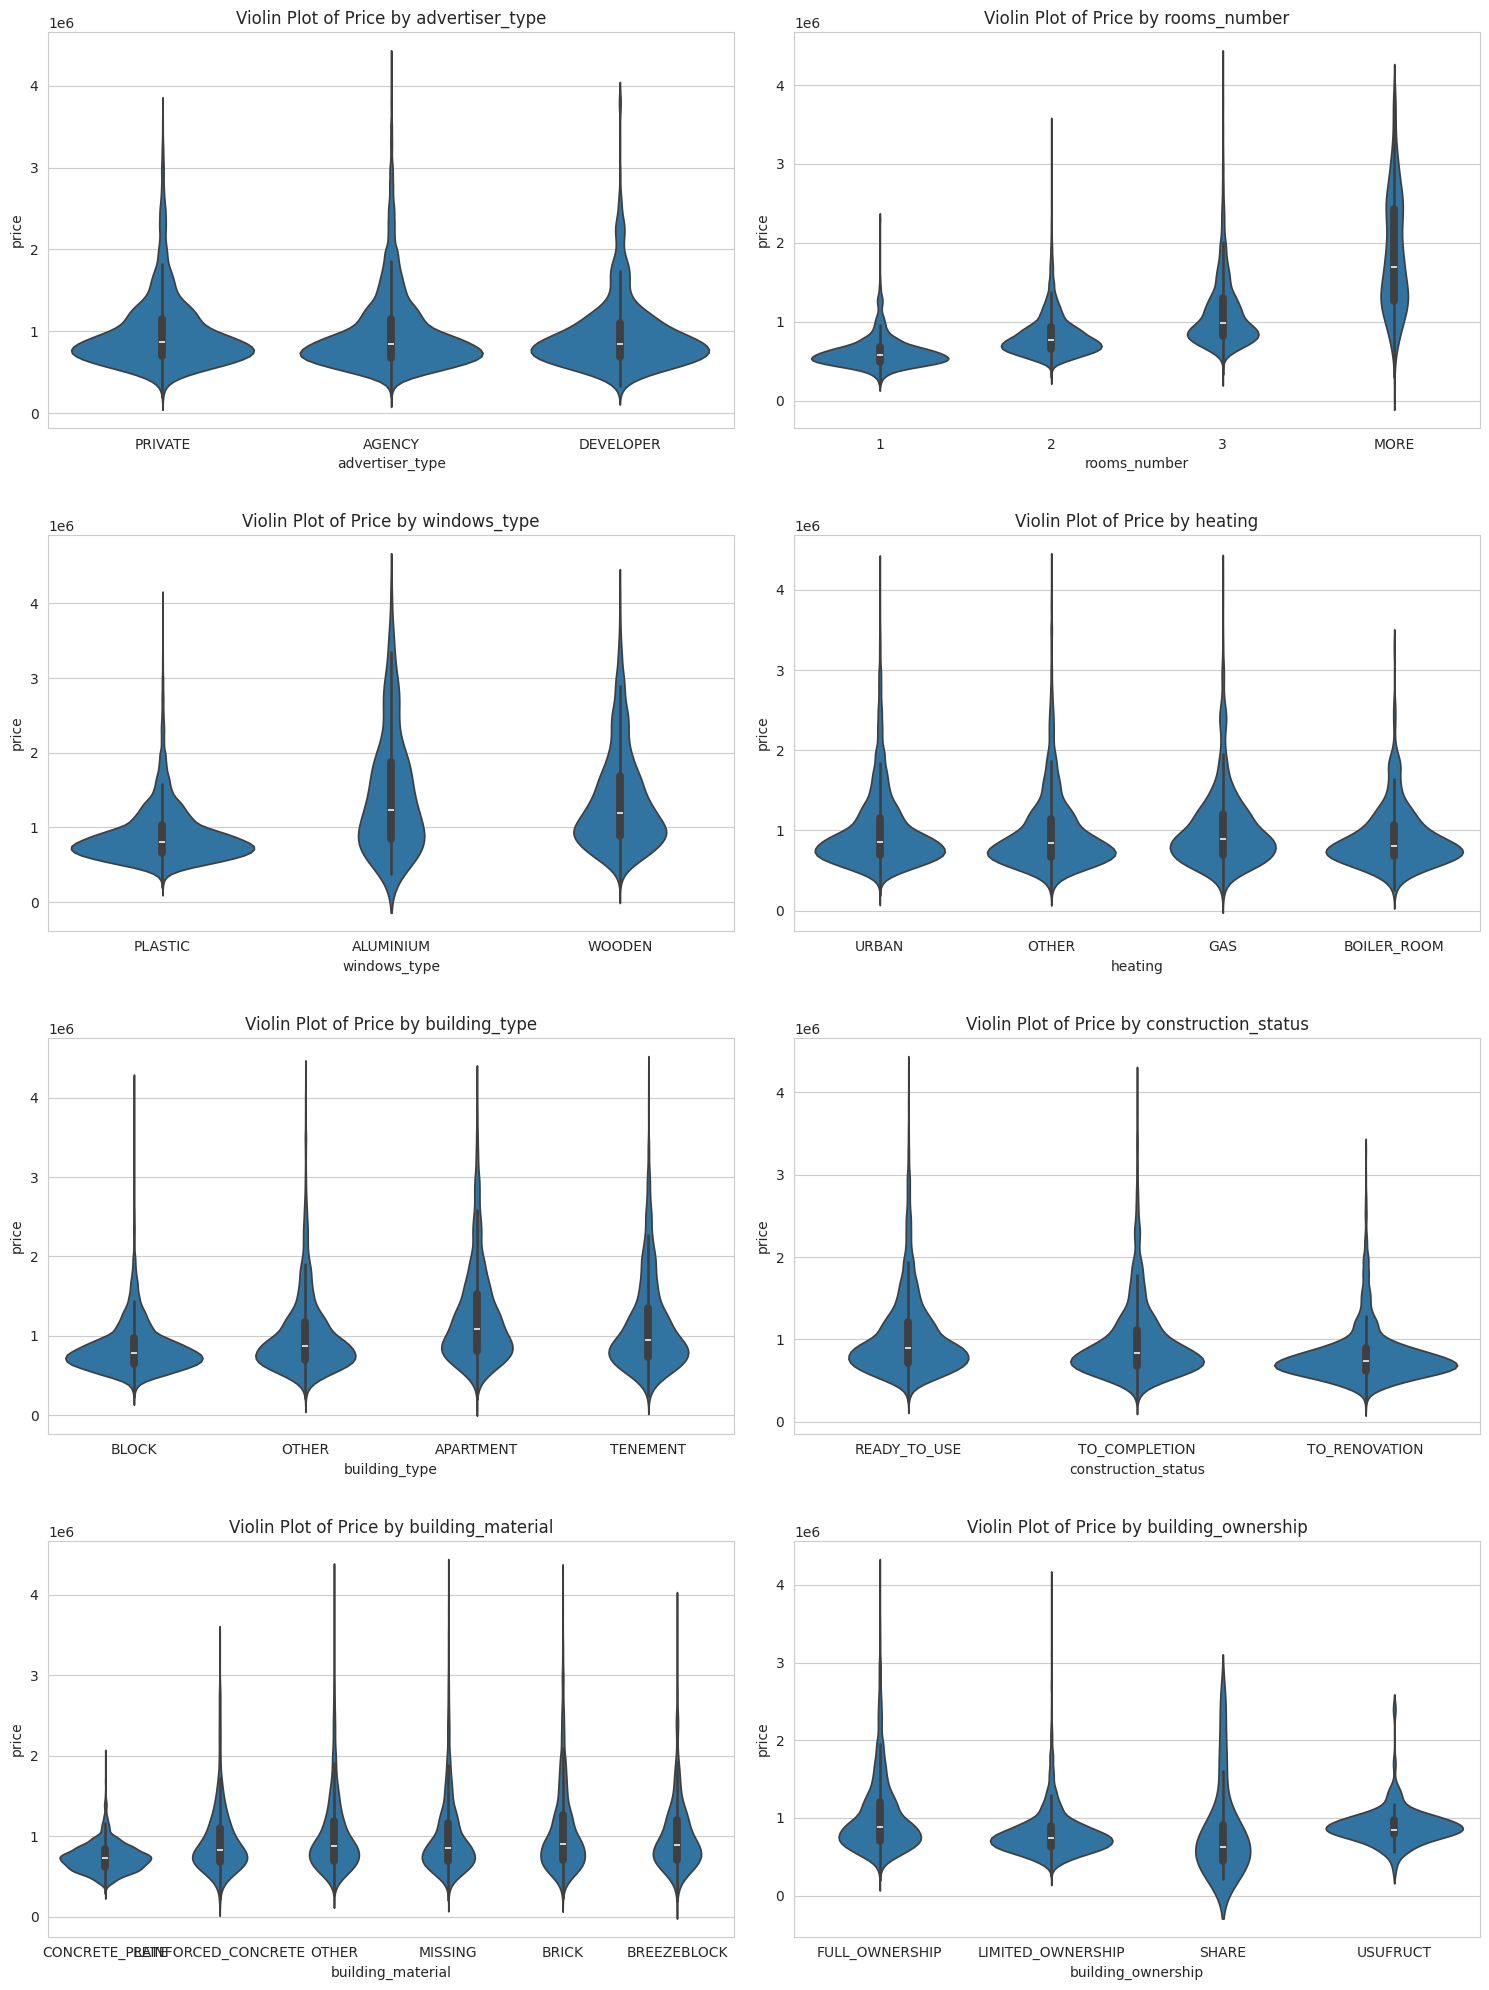

In [329]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.drop('district')

num_plots = len(categorical_columns)
num_rows = (num_plots + 1) // 2 

fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for i, column in enumerate(categorical_columns):
    sns.violinplot(x=column, y='price', data=df, ax=axes[i])
    axes[i].set_title(f'Violin Plot of Price by {column}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(h_pad=3.0)
plt.show()


From the violin plots, we can see that there are some clear differences in price according to the number of rooms. Plastic windows and blocks seem to be associated with lower prices. 

The status of the construction has an impact on price as well, properties that require renovation or are still being built tend to have lower prices.

In [330]:
df

,latitude,longitude,is_private_owner,advertiser_type,area_m2,rooms_number,floor_number,windows_type,heating,building_type,...,has_balcony,has_basement,has_garden,price,price_per_m2,building_age,distance_to_center_km,room_size_m2,floor_ratio,district
0,52.2318,20.9373,True,PRIVATE,37.0000,2,1.0000,PLASTIC,URBAN,BLOCK,...,1,1,0,610000.0000,16486.4865,55.0000,7.2758,18.5000,0.1000,wola
1,52.1812,21.0261,True,PRIVATE,54.5100,2,4.0000,PLASTIC,URBAN,BLOCK,...,1,0,0,1080000.0000,19812.8784,16.0000,6.1832,27.2550,0.2500,mokotów
2,52.2685,20.9494,True,PRIVATE,47.0000,3,2.0000,PLASTIC,URBAN,BLOCK,...,1,1,0,780000.0000,16595.7447,52.0000,7.2012,15.6667,0.5000,mokotów
4,52.2111,20.9479,False,AGENCY,25.0000,1,2.0000,NaN,OTHER,OTHER,...,1,0,0,399000.0000,15960.0000,7.0000,6.5174,25.0000,0.5000,włochy
5,52.1939,20.9226,False,AGENCY,30.9000,1,2.0000,NaN,URBAN,APARTMENT,...,1,0,0,447000.0000,14466.0194,7.0000,9.8530,30.9000,0.5000,włochy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39596,52.2458,21.1046,False,AGENCY,65.0000,3,5.0000,NaN,URBAN,APARTMENT,...,1,1,0,960000.0000,14769.2308,28.0000,11.4004,21.6667,1.0000,praga-południe
39597,52.1640,20.9929,False,AGENCY,43.0100,2,3.0000,NaN,URBAN,BLOCK,...,1,0,0,980000.0000,22785.3987,9.0000,7.6156,21.5050,0.4286,mokotów
39598,52.3211,20.9385,False,AGENCY,38.5000,2,1.0000,NaN,URBAN,BLOCK,...,0,0,0,569000.0000,14779.2208,25.0000,12.2095,19.2500,0.2000,bemowo
39599,52.2286,21.0650,False,AGENCY,57.0000,3,3.0000,NaN,URBAN,APARTMENT,...,1,0,0,1019000.0000,17877.1930,1.0000,6.9079,19.0000,0.7500,praga-północ


### One-hot encoding

In [331]:

categorical_columns = df.select_dtypes(include=['object', 'category']).columns

print("We have " + str(len(categorical_columns)) + " columns of type object to encode")
print("Names of the columns that needs to be encoded: "+ "\n" + str(categorical_columns))
df.select_dtypes(include=['object']).head()

We have 9 columns of type object to encode
Names of the columns that needs to be encoded: 
Index(['advertiser_type', 'rooms_number', 'windows_type', 'heating',
       'building_type', 'construction_status', 'building_material',
       'building_ownership', 'district'],
      dtype='object')


,advertiser_type,windows_type,heating,building_type,construction_status,building_material,building_ownership,district
0,PRIVATE,PLASTIC,URBAN,BLOCK,READY_TO_USE,CONCRETE_PLATE,NaN,wola
1,PRIVATE,PLASTIC,URBAN,BLOCK,READY_TO_USE,REINFORCED_CONCRETE,FULL_OWNERSHIP,mokotów
2,PRIVATE,PLASTIC,URBAN,BLOCK,READY_TO_USE,OTHER,LIMITED_OWNERSHIP,mokotów
4,AGENCY,NaN,OTHER,OTHER,READY_TO_USE,MISSING,FULL_OWNERSHIP,włochy
5,AGENCY,NaN,URBAN,APARTMENT,READY_TO_USE,MISSING,FULL_OWNERSHIP,włochy


In [332]:
import unicodedata
import re
from unidecode import unidecode


def clean_text(text):
    """
    Clean and normalize text to handle special characters and symbols
    """
    if pd.isna(text):
        return text

    text = str(text).lower()

    text = unidecode(text)

    text = re.sub(r'[^a-z0-9]+', '_', text)

    text = re.sub(r'_+', '_', text)
    text = text.strip('_')

    return text



for i in range(0,len(categorical_columns)):
    column = categorical_columns[i]
    df[column] = df[column].apply(clean_text)
    df = pd.concat([df,pd.get_dummies(df[column],prefix=column)],axis=1).drop([column],axis=1)

df.shape

(36724, 77)

# Modeling

### Split train test data

I'll use an 80/20 train test split stratified by the number of rooms.

In [333]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.tree import plot_tree
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split


if 'price_per_m2' in df.columns:
    df.drop(columns=['price_per_m2'], inplace=True)


target_variable = "price"

feature_names = df.columns.drop([target_variable])

df_sample = df.copy() 

cond_filter = df['price']<2000000
df_sample=df_sample[cond_filter] 


stratify_cols = [col for col in df.columns if 'rooms_number' in col]

stratify_col = df_sample[stratify_cols].apply(
    lambda row: ''.join([col.split('_')[-1] for col in stratify_cols if row[col]]),
    axis=1
)

X_train, X_test, Y_train, Y_test = train_test_split(
    df_sample[feature_names], df_sample[target_variable], 
    stratify=stratify_col,
    random_state=RANDOM_STATE,
    test_size=0.20)


Y_train_ln = np.log(Y_train)
Y_test_ln = np.log(Y_test)



In [334]:
pd.concat([
    X_train['area_m2'].describe(),
    X_test['area_m2'].describe(),
    Y_train_ln.describe(),
    Y_test_ln.describe()
], axis=1, keys=['area_train', 'area_test', 'price_train_ln', 'price_test_ln'])

,area_train,area_test,price_train_ln,price_test_ln
count,27984.0000,6996.0000,27984.0000,6996.0000
mean,52.1852,52.3466,13.6701,13.6695
std,18.1701,18.3678,0.3497,0.3488
min,12.0000,12.0000,12.2061,12.3149
25%,38.6500,38.8000,13.4284,13.4298
50%,49.0700,49.2850,13.6412,13.6401
75%,62.4000,62.6175,13.9099,13.9041
max,132.0000,130.9500,14.5087,14.5087


## Comparison of Methods

For the comparison of methods, I'll focus on the MAPE, because the focus is to have the minimum error relative to the price. However, I'll use the metrics MSE, RMSE and R2 and MAPE for a general comparison.

The methods compared are:

- Decision Tree Regressor
- XGBoost Regressor
- Random Forest Regressor



In [335]:
N_ITER = 25
SCORING='neg_mean_squared_error' # neg_mean_absolute_error, neg_mean_absolute_percentage_error

In [336]:
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, MinMaxScaler


log_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    #('log_transform', FunctionTransformer(np.log1p, validate=True))
    ('power_transform', PowerTransformer(method='yeo-johnson'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('log_transform', log_pipeline, log_transform_cols),  
        ('scaler', MinMaxScaler (), scale_cols)
    ],
    remainder=Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('passthrough', 'passthrough')
    ])
)


def get_pipeline(model):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model) 
    ])
    return pipeline

In [337]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score, mean_absolute_percentage_error


def get_metrics(Y_test, Y_predict, which=None):
    mse = mean_squared_error(Y_test, Y_predict)
    rmse = root_mean_squared_error(Y_test, Y_predict)
    r2 = r2_score(Y_test, Y_predict)
    mape = mean_absolute_percentage_error(Y_test, Y_predict)

    if which:
        print(f'{which} metrics')
    metrics_df = pd.DataFrame({'mse' : [mse], 
                            'rmse':[rmse],
                            'r2':[r2],
                            'mape':[mape], 
                           })
    display(metrics_df)
    return metrics_df

results = dict()

## Decision Tree Regressor

In [338]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

prefix = "model__"

param_dist = {
    f'{prefix}max_depth': randint(3, 200), 
    f'{prefix}min_samples_split': [5, 10, 20, 50, 100],  
    f'{prefix}min_samples_leaf': [5, 10, 20, 50], 
    f'{prefix}max_leaf_nodes': [10, 20, 30, 50, 100],
    f'{prefix}min_impurity_decrease': uniform(0, 0.1),
    f'{prefix}ccp_alpha': uniform(0, 0.05)
}


dtr = RandomizedSearchCV(
    estimator=get_pipeline(DecisionTreeRegressor()),
    param_distributions=param_dist,
    n_iter=N_ITER,
    scoring=SCORING, # neg_root_mean_squared_error, neg_mean_absolute_percentage_error
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
    error_score='raise' 
)


dtr.fit(X_train, Y_train_ln)


best_params = dtr.best_params_
print("Best Hyperparameters:", best_params)
print(f"Best score: {dtr.best_score_:.4f}")



Fitting 5 folds for each of 25 candidates, totalling 125 fits


Best Hyperparameters: {'model__ccp_alpha': 0.002261364445526903, 'model__max_depth': 42, 'model__max_leaf_nodes': 100, 'model__min_impurity_decrease': 0.038867728968948204, 'model__min_samples_leaf': 10, 'model__min_samples_split': 100}
Best score: -0.0756


In [339]:
Y_predict_train = np.exp(dtr.predict(X_train))
Y_predict_test = np.exp(dtr.predict(X_test))

get_metrics(Y_train, Y_predict_train, 'Train')
results["DecisionTreeRegressor"] = get_metrics(Y_test, Y_predict_test, 'Test')

Train metrics


,mse,rmse,r2,mape
0,77322905353.5851,278069.9649,0.3295,0.2228


Test metrics


,mse,rmse,r2,mape
0,75879028202.3391,275461.4822,0.3373,0.2223


## XGBoost

In [340]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint


param_dist = {
    f'{prefix}max_depth': randint(3, 8),
    f'{prefix}learning_rate': uniform(0.01, 0.2),
    f'{prefix}n_estimators': randint(100, 400),
    f'{prefix}min_child_weight': randint(1, 7),
    f'{prefix}subsample': uniform(loc=0.5, scale=0.5), 
    f'{prefix}colsample_bytree': uniform(loc=0.5, scale=0.5),  
    f'{prefix}gamma': uniform(0, 0.5),
    f'{prefix}reg_lambda': uniform(1, 20),  # L2 regularization  
    f'{prefix}reg_alpha': uniform(0, 10),   # L1 regularization  

}

cv = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

xgb_1 = RandomizedSearchCV(
    estimator=get_pipeline(xgb.XGBRegressor(tree_method="hist", 
                                            objective="reg:squarederror",
                                            )),
    param_distributions=param_dist,
    n_iter=N_ITER, 
    scoring=SCORING,
    cv=cv,
    n_jobs=-1
)

xgb_1.fit(X_train, Y_train_ln)

print("Best Hyperparameters:",  xgb_1.best_params_)
print(f"Best score: {xgb_1.best_score_:.4f}")


Best Hyperparameters: {'model__colsample_bytree': 0.8540362888980227, 'model__gamma': 0.010292247147901223, 'model__learning_rate': 0.20398197043239888, 'model__max_depth': 6, 'model__min_child_weight': 6, 'model__n_estimators': 393, 'model__reg_alpha': 0.007787658410143283, 'model__reg_lambda': 20.84423118582435, 'model__subsample': 0.8087407548138583}
Best score: -0.0096


In [341]:
Y_predict_train = np.exp(xgb_1.predict(X_train))

Y_predict_test = np.exp(xgb_1.predict(X_test))

get_metrics(Y_train, Y_predict_train, 'Train')
results["XGBRegressor"] = get_metrics(Y_test, Y_predict_test, 'Test')


Train metrics


,mse,rmse,r2,mape
0,4920768751.5109,70148.1914,0.9573,0.0508


Test metrics


,mse,rmse,r2,mape
0,9557428693.4711,97762.1025,0.9165,0.0695


In [342]:
best_xgb = xgb_1.best_estimator_.named_steps['model']
feature_importance = best_xgb.feature_importances_
feature_names = X_train.columns 

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)


importance_df.head(20)

,Feature,Importance
0,latitude,0.2065
1,district_wilanow,0.0770
2,building_type_block,0.0484
3,has_usable_room,0.0474
4,district_srodmiescie,0.0442
5,floor_number,0.0389
6,building_ownership_usufruct,0.0334
7,construction_status_ready_to_use,0.0319
8,building_type_apartment,0.0306
9,district_ursus,0.0262


# Quantile Regressor

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint


param_dist = {
    f'{prefix}max_depth': randint(3, 7),
    f'{prefix}learning_rate': uniform(0.01, 0.1),
    f'{prefix}n_estimators': randint(100, 300),
    f'{prefix}min_child_weight': randint(1, 10),
    f'{prefix}subsample': uniform(0.8, 0.2), 
    f'{prefix}colsample_bytree': uniform(0.8, 0.2),
    f'{prefix}gamma': uniform(0, 0.5),  # Added gamma for regularization
    f'{prefix}reg_lambda': uniform(1, 20),  # L2 regularization
    f'{prefix}reg_alpha': uniform(0, 10),   # L1 regularization

}

xgbq_model = xgb.XGBRegressor(tree_method="hist", objective='reg:quantileerror', quantile_alpha=0.5)
                 
CV = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

xbg_q = RandomizedSearchCV(
    estimator=get_pipeline(xgbq_model),
    param_distributions=param_dist,
    n_iter=N_ITER, 
    scoring=SCORING,
    cv=CV,
    n_jobs=-1
)

xbg_q.fit(X_train, Y_train_ln)


xbg_q.best_params_


KeyboardInterrupt: 

In [ ]:
Y_predict_train = np.exp(xbg_q.predict(X_train))
Y_predict_test = np.exp(xbg_q.predict(X_test))

get_metrics(Y_train, Y_predict_train, 'Train')
results["XGBRegressorQuantile"] = get_metrics(Y_test, Y_predict_test, 'Test')

Train metrics


,mse,rmse,r2,mape
0,2753377701.2628,52472.6376,0.8779,0.0492


Test metrics


,mse,rmse,r2,mape
0,3703417155.6816,60855.7077,0.8359,0.0614


In [ ]:
best_xgb = xbg_q.best_estimator_.named_steps['model']
feature_importance = best_xgb.feature_importances_
feature_names = X_train.columns 

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)


importance_df.head(10)

,Feature,Importance
58,district_ursynow,0.0073
59,building_material_brick,0.0071
60,district_praga_poludnie,0.0071
61,has_oven,0.0070
62,heating_other,0.0067
63,has_fridge,0.0067
64,has_usable_room,0.0063
65,building_material_reinforced_concrete,0.0062
66,has_stove,0.0060
67,building_material_other,0.0057


## RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import numpy as np


param_dist = {
    f'{prefix}n_estimators': randint(50, 500),
    f'{prefix}max_depth': randint(1, 20),
    f'{prefix}min_samples_split': randint(2, 20),
    f'{prefix}min_samples_leaf': randint(1, 10),
    f'{prefix}max_features': ['sqrt', 'log2', None],
    f'{prefix}bootstrap': [True, False],
    f'{prefix}criterion': ['friedman_mse', 'squared_error', 'poisson'], #{'friedman_mse', 'squared_error', 'absolute_error', 'poisson'}
}


rf = get_pipeline(RandomForestRegressor(random_state=RANDOM_STATE))


random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=N_ITER, 
    cv=CV,
    scoring=SCORING, 
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
    return_train_score=True
)


random_search.fit(X_train, Y_train)

print("Best parameters found:")
print(random_search.best_params_)
print(f"\nBest cross-validation score: {random_search.best_score_:.3f}")

# Get the best model
best_rf = random_search.best_estimator_


Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [203]:
Y_predict_train = best_rf.predict(X_train)
Y_predict_test = best_rf.predict(X_test)

get_metrics(Y_train, Y_predict_train, 'Train')
results["RandomForestRegressor"] = get_metrics(Y_test, Y_predict_test, 'Test')

Train metrics


,mse,rmse,r2,mape
0,7266688044.7975,85244.8711,0.6778,0.0951


Test metrics


,mse,rmse,r2,mape
0,7620211670.3355,87293.8238,0.6623,0.0981


In [ ]:
## Add final comparison table for all methods
pd.set_option('display.float_format', '{:.4f}'.format)  
combined_results = pd.concat(
    {model: df.T for model, df in results.items()}, 
    axis=1
)

combined_results.columns = combined_results.columns.droplevel(1) 

combined_results

,DecisionTreeRegressor,XGBRegressor
mse,75879028202.3391,9557428693.4711
rmse,275461.4822,97762.1025
r2,0.3373,0.9165
mape,0.2223,0.0695


# Summary and conclusions


Selected model is XGBoost Regressor due to lower RMSE and MAPE.

The resulting MAPE of 6% seems acceptable for the purpose of assisting owners, developers and agencies in assesing the price of their property. QuantileRegressor seems particulartly useful for providing ranges in price for a given property.

Further improvements can be made with including POI (Point of Interest) data, that can tell us more about the surroundings of this property and whether is close to valuable infrastructure such as metro and others. 

Additionally, the images of the property may be used as features to predict price. Both issues will be addressed in my master thesis.

